## Models

We can now load in the 4 dataframes for the 4 groups of predictors, and then merge them into a master predictor dataframe. We can then run different models on the master dataframe, and figure out which model is best.

In [311]:
# Import libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import requests
import sklearn

from collections import Counter

# Import sklearn functions
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

%matplotlib inline

In [242]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14, labelpad=20)
    return fig

We can load in the original X dataframe, the binarized y target vector, and then all of the dataframes that were cleaned up and dummified in notebook 2.

In [3]:
with open('data/full_X_y_df.pkl', 'rb') as picklefile:
    [X_orig, y] = pickle.load(picklefile)

with open("pkls/dem_hosp_dx_proc_orig_X_dfs.pkl", "rb") as picklefile:
    [X_demographic_predictors_dummified, X_hospital_predictors_df, X_diagnoses_df, X_procedures_df, X] = pickle.load(picklefile)

In [4]:
X_poa_diags = X_diagnoses_df.filter(regex=r'Y', axis=1)
X_not_poa_diags = X_diagnoses_df.filter(regex=r'N', axis=1)

In [5]:
# Let's join all of the dataframes on the index, which is the same for all of them since the row index is the
# record number of the discharge.

X_clean_dummified_full = X_demographic_predictors_dummified.merge(X_hospital_predictors_df, left_index=True, right_index=True)
X_clean_dummified_full = X_clean_dummified_full.merge(X_diagnoses_df, left_index=True, right_index=True)
X_clean_dummified_full = X_clean_dummified_full.merge(X_procedures_df, left_index=True, right_index=True)

In [6]:
print(X_clean_dummified_full.shape)

(12704, 135)


We now perform a gridsearch using different models with different parameters to find the best estimator on the full cleaned & dummified dataframe.

The notebook that goes over part of this is kiwi_detector_code from 7/27/18. But the full example of gridsearchcv with multiple parameter grids was covered in a pair programming notebook: https://github.com/thisismetis/sf18_ds11/blob/master/class_lectures/week04-mcnulty1/05-trees_forests/pair_problem_solution.ipynb

In [7]:
# First, let's split our data set into a training set and a final test set.
X_train, X_test, y_train, y_test = train_test_split(X_clean_dummified_full, y, test_size=0.2, stratify=y)

In [8]:
# The only two variables that are continuous in all of X are patient age (which is actually ordinal, since ages
# are binned into groups, which aren't actually evenly spaced; however I don't think it will have a huge influence
# on the accuracy of the model) and length of stay, which actually is continuous.

# All other variables are either binary/boolean, or are dummy variables that are 0 or 1. Therefore the only two
# columns that will get scaled are patient age and length of stay.

ssX = StandardScaler()

X_train_to_scale = X_train[['pat_age', 'length_of_stay']].copy()
X_train_scaled = ssX.fit_transform(X_train_to_scale)

X_test_to_scale = X_test[['pat_age', 'length_of_stay']].copy()
X_test_scaled = ssX.transform(X_test_to_scale)

X_train.loc[:, 'pat_age'] = X_train_scaled[:, 0]
X_train.loc[:, 'length_of_stay'] = X_train_scaled[:, 1]
X_test.loc[:, 'pat_age'] = X_test_scaled[:, 0]
X_test.loc[:, 'length_of_stay'] = X_test_scaled[:, 1]

/Users/joycelee/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
X_test['pat_age'].describe()

count    2541.000000
mean        0.041577
std         0.964660
min        -4.053548
25%        -0.357400
50%         0.170621
75%         0.698642
max         1.490674
Name: pat_age, dtype: float64

In [10]:
X_test['length_of_stay'].describe()

count    2541.000000
mean        0.008743
std         0.955140
min        -0.564326
25%        -0.495379
50%        -0.288537
75%         0.194095
max        14.052510
Name: length_of_stay, dtype: float64

In [11]:
with open("pkls/scaled_X_train_test_y_train_test.pkl", "wb") as picklefile:
    pickle.dump([X_train, X_test, y_train, y_test], picklefile)

## GridsearchCV

We'll use gridsearchCV in order to compare the accuracy of different models, and also to use different metrics to score our model. Running KNN and SVC took too long to run, and also it makes no sense to run KNN with 135 predictors.

In [ ]:
models = [('svm', SVC),
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('gradient boosted tree', GradientBoostingClassifier),
          ('mlpc', MLPClassifier)
         ]

param_choices = [
    {
        'C': [0.1, 1.0, 10],
        'gamma': [0.01, 0.1, 1] ,
        'probability': [True]
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [2, 4, 6, 8],
        'min_samples_leaf': [5, 10, 15]
    },
    {
        'hidden_layer_sizes': [50, 100, 150],
        'alpha': [0.00001, 0.0001, 0.001],
        'max_iter': [1000]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    print("Doing grid search for {}.".format(name))
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}"
    print(s)
    grids[name] = grid

In [ ]:
with open("pkls/svm_logr_tree_forest_mlp_gridsearch.pkl", "wb") as picklefile:
    pickle.dump(grids, picklefile)

In [ ]:
with open("pkls/svm_logr_tree_forest_mlp_gridsearch.pkl", "rb") as picklefile:
    grids = pickle.load(picklefile)

In [192]:
gbc = GradientBoostingClassifier()

parameters = {
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [2, 4, 6, 8],
        'min_samples_leaf': [5, 10, 15]
    }

grid = GridSearchCV(gbc, param_grid=parameters)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
grids['gradient boosted tree'] = grid

In [189]:
grids

{'svm': GridSearchCV(cv=None, error_score='raise',
        estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
        fit_params=None, iid=True, n_jobs=1,
        param_grid={'C': [0.1, 1.0, 10], 'gamma': [0.01, 0.1, 1], 'probability': [True]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=0),
 'logistic': GridSearchCV(cv=None, error_score='raise',
        estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
        fit_params=None, iid=True, n_jobs=1,
        param_grid={'C': array([1.00000e-03, 6.57933e-03, 4.32876e-02, 2.

In [17]:
for name, model in grids.items():
    model.best_estimator_.fit(X_train, y_train)
    y_train_pred = model.best_estimator_.predict(X_train)
    acc_score = accuracy_score(y_train, y_train_pred)
    print("The accuracy for {} on the training set is {}".format(name, str(acc_score)))
    print(classification_report(y_train, y_train_pred))
    
    y_test_pred = model.best_estimator_.predict(X_test)
    acc_score = accuracy_score(y_test, y_test_pred)
    print("The accuracy for {} on the test set is {}".format(name, str(acc_score)))
    print(classification_report(y_test, y_test_pred))
    print("_____________\n")

The accuracy for svm on the training set is 0.864311718980616
             precision    recall  f1-score   support

      alive       0.84      0.70      0.76      3177
    expired       0.87      0.94      0.90      6986

avg / total       0.86      0.86      0.86     10163

The accuracy for svm on the test set is 0.8248720975993703
             precision    recall  f1-score   support

      alive       0.75      0.65      0.70       794
    expired       0.85      0.90      0.88      1747

avg / total       0.82      0.82      0.82      2541

_____________

The accuracy for logistic on the training set is 0.8072419561153202
             precision    recall  f1-score   support

      alive       0.76      0.56      0.64      3177
    expired       0.82      0.92      0.87      6986

avg / total       0.80      0.81      0.80     10163

The accuracy for logistic on the test set is 0.7961432506887053
             precision    recall  f1-score   support

      alive       0.73      0.55 

In [196]:
y_train_pred = grids['svm'].best_estimator_.predict(X_train)

In [197]:
confusion_matrix(y_train, y_train_pred)

array([[2231,  946],
       [ 433, 6553]])

In [18]:
roc_plotting_stuff = []
for name, model in grids.items():
    model.best_estimator_.fit(X_train, y_train)
    preds = model.best_estimator_.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, preds[:,1], pos_label='expired')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))

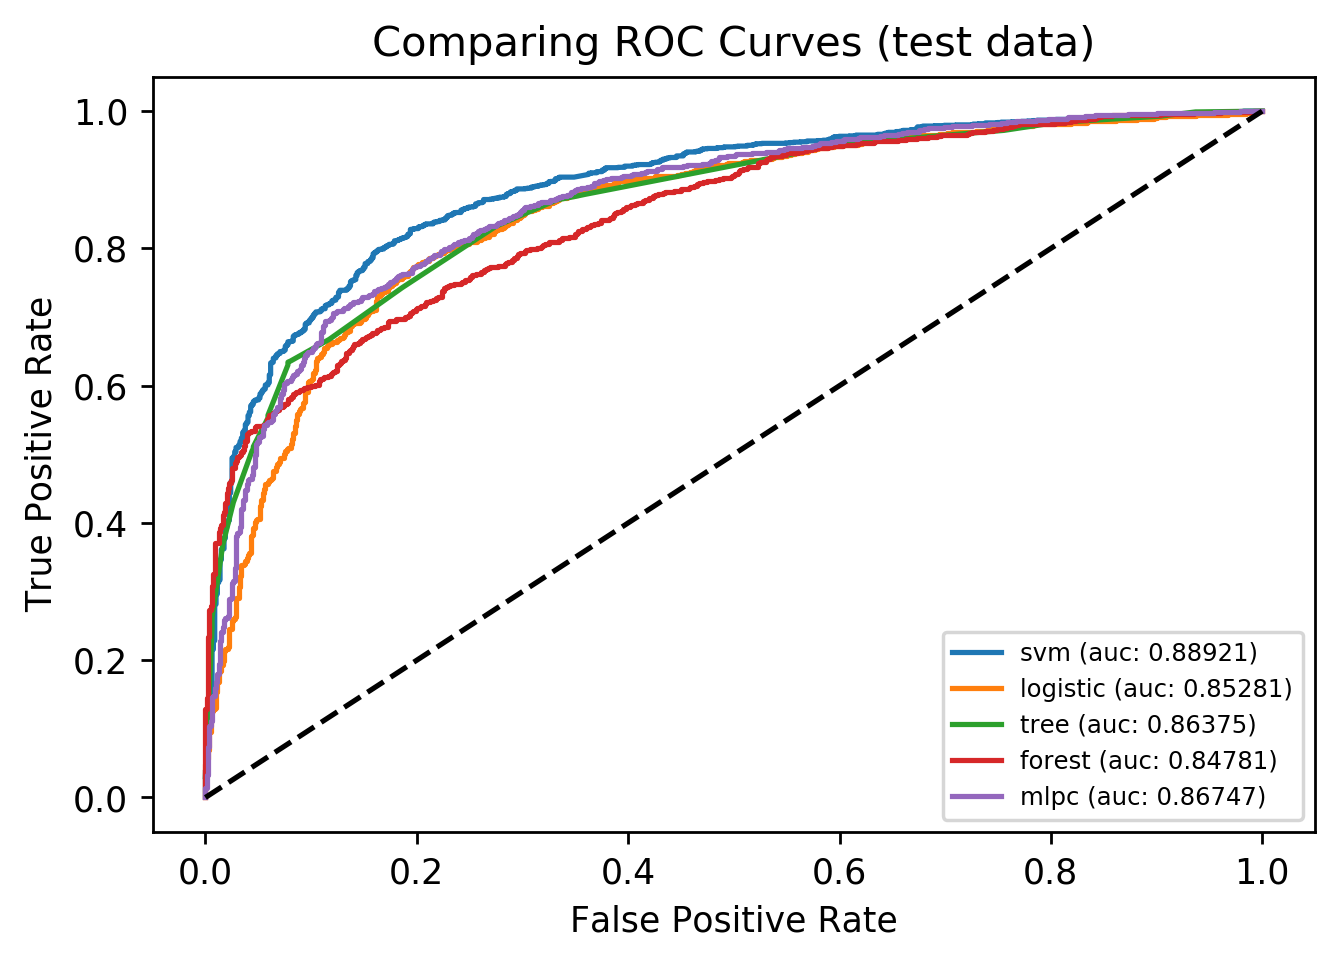

In [21]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.5f)'%auc_score)
plt.legend(loc='lower right', fontsize=7)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves (test data)");

fig = plt.gcf()
fig.savefig('ROC_curves.png')

In [23]:
from sklearn.naive_bayes import BernoulliNB

In [26]:
X_train_for_bnb = X_train.drop(['pat_age', 'length_of_stay'], axis=1)
X_test_for_bnb = X_test.drop(['pat_age', 'length_of_stay'], axis=1)

bnb = BernoulliNB()
bnb.fit(X_train_for_bnb, y_train)
bnb.score(X_train_for_bnb, y_train)
y_bnb_test_pred = bnb.predict(X_test_for_bnb)

In [29]:
print(accuracy_score(y_test, y_bnb_test_pred))
print(confusion_matrix(y_test, y_bnb_test_pred))

0.7465564738292011
[[ 412  382]
 [ 262 1485]]


In [31]:
y_bnb_pred_probs = bnb.predict_proba(X_test_for_bnb)
fpr, tpr, _ = roc_curve(y_test, y_bnb_pred_probs[:,1], pos_label='expired')
auc_score = auc(fpr, tpr)

In [32]:
auc_score

0.7675518593227109

Let's also try a gradient boosted tree:

In [178]:
from sklearn.ensemble import GradientBoostingClassifier

In [211]:
gbc = GradientBoostingClassifier()

gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [212]:
gbc.score(X_train, y_train)

0.8489619206927088

In [213]:
y_gbc_test_pred = gbc.predict(X_test)

In [214]:
print(accuracy_score(y_test, y_gbc_test_pred))
print(classification_report(y_test, y_gbc_test_pred))

0.8319559228650137
             precision    recall  f1-score   support

      alive       0.75      0.69      0.72       794
    expired       0.86      0.90      0.88      1747

avg / total       0.83      0.83      0.83      2541



In [215]:
y_gb_test_probs = gbc.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_gb_test_probs[:, 1], pos_label='expired')
auc_score = auc(fpr, tpr)

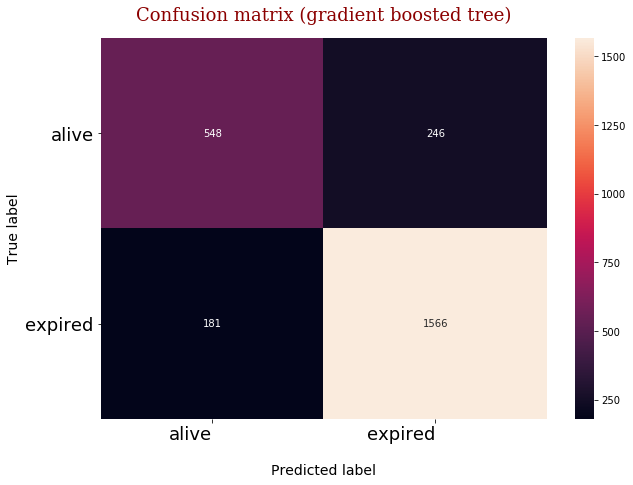

<Figure size 432x288 with 0 Axes>

In [252]:
cm = confusion_matrix(y_test, y_gbc_test_pred)
fig = print_confusion_matrix(cm, class_names=['alive', 'expired'], fontsize=18)

font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 18,
        }

plt.title("Confusion matrix (gradient boosted tree)", fontdict=font, y=1.03)
plt.show()

fig = plt.gcf()
fig.savefig('gradient_boosted_tree.png')

In [216]:
auc_score

0.90097850363127

In [217]:
roc_plotting_stuff.append(('gb_tree', tpr, fpr, auc_score))

In [219]:
del roc_plotting_stuff[5]

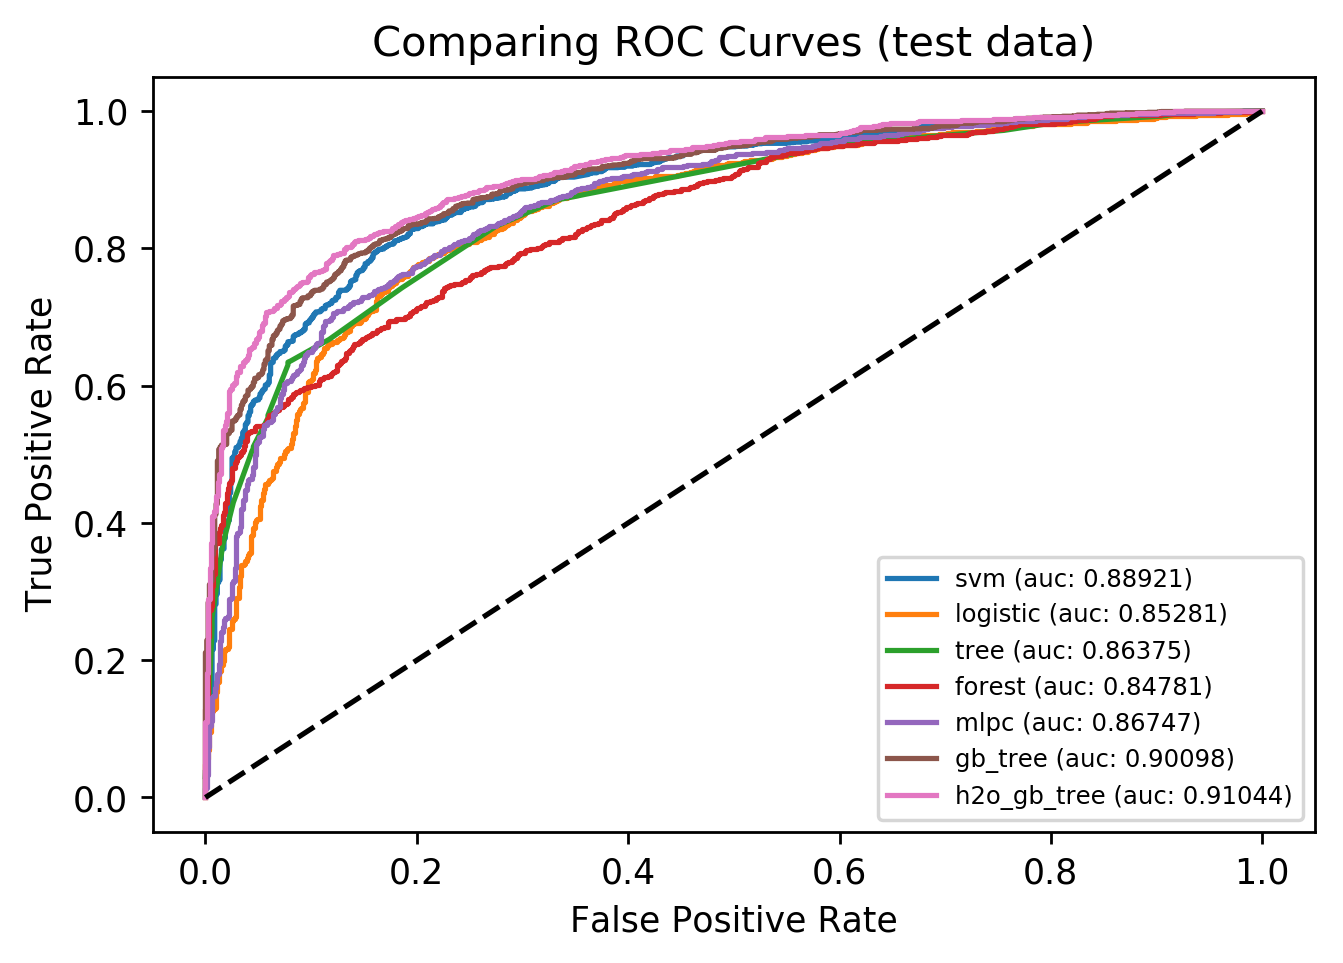

In [253]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.5f)'%auc_score)
plt.legend(loc='lower right', fontsize=7)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves (test data)");

fig = plt.gcf()
fig.savefig('ROC_curves.png')

In [254]:
# Let's add the h2o gradient boosted tree ROC curve to this graph.
with open("pkls/y_h2o_test_df_2.pkl", "rb") as picklefile:
    y_h2o_test_df = pickle.load(picklefile)

In [263]:
y_h2o_test_df.head()

,target,predict,alive,expired
0,alive,alive,0.815967,0.184033
1,expired,expired,0.051861,0.948139
2,alive,expired,0.180125,0.819875
3,expired,expired,0.057768,0.942232
4,expired,expired,0.195606,0.804394


In [277]:
acc = accuracy_score(y_h2o_test_df['target'], y_h2o_test_df['predict'])

print("Overall accuracy: " + "{:.5f}".format(acc) + "\n")

print(classification_report(y_h2o_test_df['target'], y_h2o_test_df['predict'], digits=5))

Overall accuracy: 0.83078

             precision    recall  f1-score   support

      alive    0.74932   0.68892   0.71785       794
    expired    0.86361   0.89525   0.87915      1747

avg / total    0.82790   0.83078   0.82874      2541



In [264]:
y_h2o_gb_test_probs = y_h2o_test_df['predict']
fpr, tpr, _ = roc_curve(y_h2o_test_df['target'], y_h2o_test_df['expired'], pos_label='expired')
auc_score = auc(fpr, tpr)

In [265]:
roc_plotting_stuff.append(('h2o_gb_tree', tpr, fpr, auc_score))

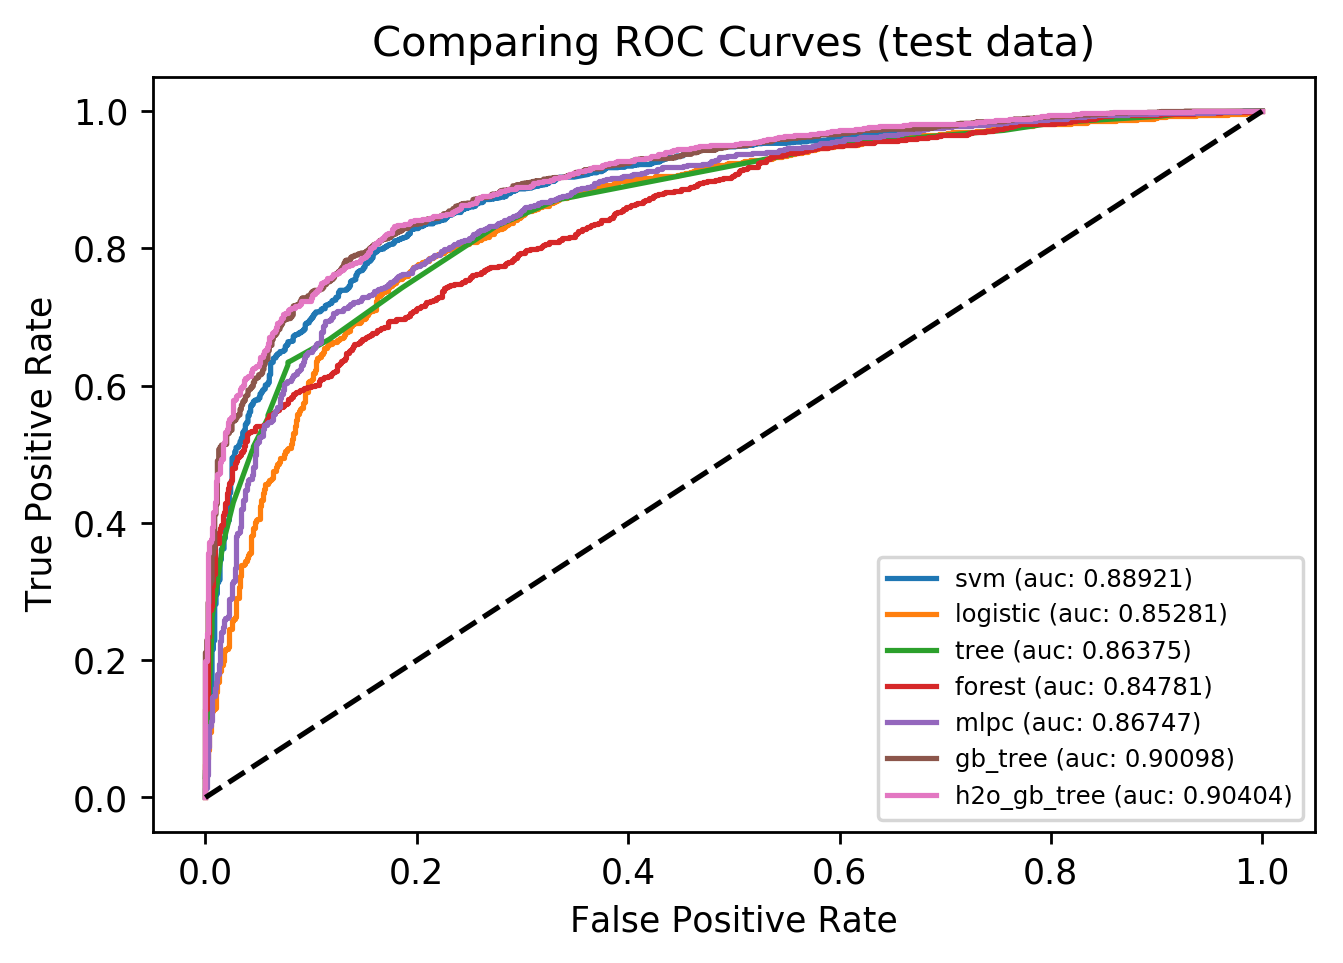

In [266]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.5f)'%auc_score)
plt.legend(loc='lower right', fontsize=7)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves (test data)");

fig = plt.gcf()
fig.savefig('ROC_curves.png')

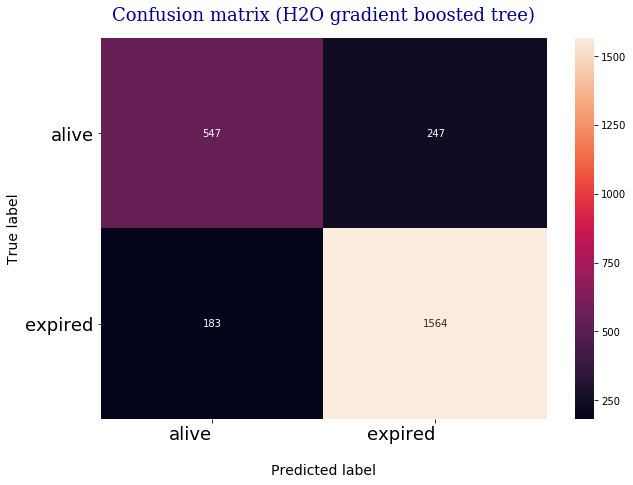

In [269]:
cm = confusion_matrix(y_h2o_test_df['target'], y_h2o_test_df['predict'])
fig = print_confusion_matrix(cm, class_names=['alive', 'expired'], fontsize=18)

font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 18,
        }

plt.title("Confusion matrix (H2O gradient boosted tree)", fontdict=font, y=1.03)
plt.show()

# fig = plt.gcf()
fig.savefig('h2o_gradient_boosted_tree.png')

In [278]:
with open("pkls/y_h2o_full_df.pkl", "rb") as picklefile:
    y_h2o_full_df = pickle.load(picklefile)

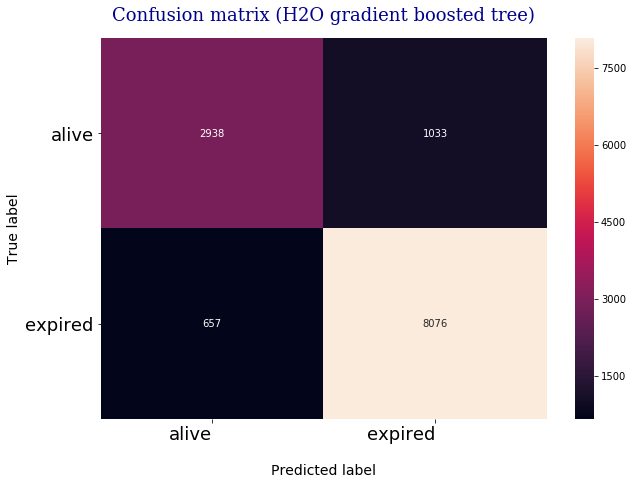

In [282]:
cm = confusion_matrix(y_h2o_full_df['target'], y_h2o_full_df['predict'])
fig = print_confusion_matrix(cm, class_names=['alive', 'expired'], fontsize=18)

font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 18,
        }

plt.title("Confusion matrix (H2O gradient boosted tree)", fontdict=font, y=1.03)
plt.show()

fig.savefig('full_confusion_matrix.png')

In [284]:
print(accuracy_score(y_h2o_full_df['target'], y_h2o_full_df['predict']))
print("\n")
print(classification_report(y_h2o_full_df['target'], y_h2o_full_df['predict'], digits=5))

0.866971032745592


             precision    recall  f1-score   support

      alive    0.81725   0.73986   0.77663      3971
    expired    0.88660   0.92477   0.90528      8733

avg / total    0.86492   0.86697   0.86507     12704



## PCA for dimensionality reduction

The next things to tackle here are to 1) try PCA to reduce dimensionality, and then run all these estimators on the pca transformed data points, and compare accuracy. 2) Scramble each column and see how much the accuracy drops for each column (or how much the recall drops, or how much the f1 score drops), and use this to rank importance. 3) Pick the top 50 or so features that have the lowest p values, and re-run the model on that, and see how it works.

In [33]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA(0.95)
X_principal_components = pca.fit_transform(X_train)
X_test_principal_components = pca.transform(X_test)

In [44]:
X_principal_components.shape[1]

79

In [47]:
col_names = ['PCA ' + str(i) for i in range(1, X_principal_components.shape[1] + 1)]

In [49]:
X_principal_components_df = pd.DataFrame(X_principal_components, columns=col_names)

In [50]:
X_test_principal_components_df = pd.DataFrame(X_test_principal_components, columns=col_names)

In [51]:
X_principal_components_df.shape #The first 79 principal components account for 95% of the variance.

(10163, 79)

In [53]:
models = [('svm', SVC),
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('mlpc', MLPClassifier)
         ]

param_choices = [
    {
        'C': [0.1, 1.0, 10],
        'gamma': [0.01, 0.1, 1] ,
        'probability': [True]
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'hidden_layer_sizes': [50, 100, 150],
        'alpha': [0.00001, 0.0001, 0.001],
        'max_iter': [1000]
    }
]

grids_pca = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    print("Doing grid search for {}.".format(name))
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}"
    print(s)
    grids_pca[name] = grid

Doing grid search for svm.
svm: best score: 0.8280035422611434
Doing grid search for logistic.
logistic: best score: 0.7995670569713668
Doing grid search for tree.
tree: best score: 0.79326970382761
Doing grid search for forest.
forest: best score: 0.7741808521105973
Doing grid search for mlpc.
mlpc: best score: 0.8134409131162058


There's essentially no improvement with doing PCA, although it does cut down the total number of componenets to 79 rather than 135.

Running gridsearch on raw data, not PCA:
    
    Doing grid search for svm.
    svm: best score: 0.8280035422611434
    Doing grid search for logistic.
    logistic: best score: 0.7995670569713668
    Doing grid search for tree.
    tree: best score: 0.79326970382761
    Doing grid search for forest.
    forest: best score: 0.7744760405392108
    Doing grid search for mlpc.
    mlpc: best score: 0.812063367116009

## Evaluating feature importance

There are 4 ways that we can look at feature importance:
1. Sort the coefficients of the best logistic regression model
2. Look at the feature importance of the best decision tree model
3. Look at the feature importance of the best random forest model
4. Scramble each column iteratively and calculate how much the auc_score drops.

In [150]:
set(X_train.columns).difference(set(X_train_logr))

{'ethnicity_`',
 'first_payment_src_ZZ',
 'hospital_community',
 'public_health_region_11',
 'race_`',
 'sex_code_U',
 'type_of_admission_9'}

In [146]:
# Okay, let's drop one of the dummy columns in order to run logistic regression, so as to avoid the dummy trap.
X_train_logr = X_train.drop(['sex_code_U', 'race_`', 'ethnicity_`', 'public_health_region_11', 'first_payment_src_ZZ', 'type_of_admission_9', 'hospital_community'], axis=1)

In [120]:
grids['logistic'].fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 6.57933e-03, 4.32876e-02, 2.84804e-01, 1.87382e+00,
       1.23285e+01, 8.11131e+01, 5.33670e+02, 3.51119e+03, 2.31013e+04,
       1.51991e+05, 1.00000e+06]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [135]:
best_logr_no_drop = grids['logistic'].best_estimator_
feature_logr_coef = list(zip(X_train.columns, best_logr.coef_[0]))

sorted_logr_feature_importance_no_drop = sorted(feature_logr_coef, key=lambda x: x[1], reverse=True)

sorted_logr_feature_importance_no_drop[0:10]

[('type_of_admission_4', 7.868230978953389),
 ('first_payment_src_AM', 4.282000202112096),
 ('first_payment_src_LM', 3.3482524833841767),
 ('sex_code_U', 2.376419124035444),
 (('3481', 'Y'), 1.4446389286699395),
 ('hospital_teaching', 1.1922030401284578),
 ('hospital_community', 1.163168656464371),
 (('3481', 'N'), 1.131355603738501),
 ('source_of_admission_D', 1.0673792999037293),
 ('source_of_admission_4', 0.7947300265169935)]

In [153]:
len(sorted_logr_feature_importance_no_drop)

135

In [147]:
grids['logistic'].fit(X_train_logr, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 6.57933e-03, 4.32876e-02, 2.84804e-01, 1.87382e+00,
       1.23285e+01, 8.11131e+01, 5.33670e+02, 3.51119e+03, 2.31013e+04,
       1.51991e+05, 1.00000e+06]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [149]:
# Let's look at the sorted features for the best logistic regression model that gridsearch found.
best_logr = grids['logistic'].best_estimator_
feature_logr_coef = list(zip(X_train_logr.columns, best_logr.coef_[0]))

sorted_logr_feature_importance = sorted(feature_logr_coef, key=lambda x: x[1], reverse=True)

sorted_logr_feature_importance[0:10]

[('type_of_admission_4', 6.911404115652576),
 ('first_payment_src_AM', 3.326351429914172),
 ('first_payment_src_LM', 2.3520554266095894),
 (('3481', 'Y'), 1.441893544261178),
 ('source_of_admission_D', 1.1764528444577236),
 (('3481', 'N'), 1.126266338200329),
 ('source_of_admission_4', 0.8969360043271896),
 ('source_of_admission_6', 0.8422839332306858),
 ('first_payment_src_OF', 0.7672840771803586),
 ('3761', 0.6647717436174556)]

In [154]:
len(sorted_logr_feature_importance)

128

In [68]:
best_tree = grids['tree'].best_estimator_
feature_tree_coef = list(zip(X_train.columns, best_tree.feature_importances_))

sorted_tree_feature_importance = sorted(feature_tree_coef, key=lambda x: x[1], reverse=True)

In [69]:
best_forest = grids['forest'].best_estimator_
feature_forest_coef = list(zip(X_train.columns, best_forest.feature_importances_))

sorted_forest_feature_importance = sorted(feature_forest_coef, key=lambda x: x[1], reverse=True)

In [155]:
# Logistic regression coefficients with highest positive values.
sorted_logr_feature_importance[0:10]

[('type_of_admission_4', 6.911404115652576),
 ('first_payment_src_AM', 3.326351429914172),
 ('first_payment_src_LM', 2.3520554266095894),
 (('3481', 'Y'), 1.441893544261178),
 ('source_of_admission_D', 1.1764528444577236),
 (('3481', 'N'), 1.126266338200329),
 ('source_of_admission_4', 0.8969360043271896),
 ('source_of_admission_6', 0.8422839332306858),
 ('first_payment_src_OF', 0.7672840771803586),
 ('3761', 0.6647717436174556)]

In [156]:
# Logistic regression coefficients with the lowest negative values.
sorted_logr_feature_importance[-10:]

[('public_health_region_02', -0.6586364825368008),
 ('4311', -0.6682138726091591),
 ('out_of_hospital_cardiac_arrest', -0.7047503046474283),
 ('ethnicity_2', -0.7123177333906194),
 ('3722', -0.7574824473134377),
 (('5180', 'N'), -0.8078818685636604),
 ('source_of_admission_7', -0.8192829770045654),
 ('311', -1.093702973111971),
 ('length_of_stay', -1.1850734745235723),
 ('first_payment_src_14', -2.3502440805296256)]

In [157]:
sorted_tree_feature_importance[0:20]

[('length_of_stay', 0.6794432911791964),
 ('8856', 0.07794161951455171),
 ('3722', 0.06731338979993301),
 ('out_of_hospital_cardiac_arrest', 0.04216836215574824),
 ('9672', 0.031782059113617894),
 ('311', 0.02501667243089551),
 (('51881', 'Y'), 0.019696919831512037),
 ('pat_age', 0.01807125225790521),
 ('9604', 0.017489215513307888),
 (('3481', 'Y'), 0.01689218096313012),
 ('source_of_admission_4', 0.0016443487097856035),
 ('9671', 0.0013800406663484496),
 ('type_of_admission_1', 0.0005203409536797444),
 (('496', 'Y'), 0.00036567072924851613),
 ('public_health_region_11', 0.0002746361811396193),
 ('sex_code_F', 0.0),
 ('sex_code_M', 0.0),
 ('sex_code_U', 0.0),
 ('race_1', 0.0),
 ('race_2', 0.0)]

In [176]:
dx_query = "https://clinicaltables.nlm.nih.gov/api/icd9cm_dx/v3/search?terms={}"
proc_query = "https://clinicaltables.nlm.nih.gov/api/icd9cm_sg/v3/search?terms={}"

for feature in sorted_tree_feature_importance[0:20]:
    try:
        int(feature[0])
        response = requests.get(proc_query.format(feature[0]))
        val = response.json()
        print(val[3][0][1].strip())
#         print(feature[0])
#         print("\n")
    except:
        if type(feature[0]) == tuple:
            response = requests.get(dx_query.format(feature[0][0]))
            val = response.json()
            print(val[3][0][1].strip())
#             print("this is a tuple")
#             print(feature[0][0])
#             print("\n")
        else:
            print(feature[0])

length_of_stay
Coronary arteriography using two catheters
Left heart cardiac catheterization
out_of_hospital_cardiac_arrest
Continuous invasive mechanical ventilation for 96 consecutive hours or more
Temporary tracheostomy
Acute respiratory failure
pat_age
Insertion of endotracheal tube
Anoxic brain damage
source_of_admission_4
Continuous invasive mechanical ventilation for less than 96 consecutive hours
type_of_admission_1
Chronic airway obstruction, not elsewhere classified
public_health_region_11
sex_code_F
sex_code_M
sex_code_U
race_1
race_2


In [177]:
for feature in sorted_forest_feature_importance[0:20]:
    try:
        int(feature[0])
        response = requests.get(proc_query.format(feature[0]))
        val = response.json()
        print(val[3][0][1].strip())
#         print(feature[0])
#         print("\n")
    except:
        if type(feature[0]) == tuple:
            response = requests.get(dx_query.format(feature[0][0]))
            val = response.json()
            print(val[3][0][1].strip())
#             print("this is a tuple")
#             print(feature[0][0])
#             print("\n")
        else:
            print(feature[0])

length_of_stay
Coronary arteriography using two catheters
Left heart cardiac catheterization
Temporary tracheostomy
Angiocardiography of left heart structures
Continuous invasive mechanical ventilation for less than 96 consecutive hours
Percutaneous transluminal coronary angioplasty [PTCA]
Continuous invasive mechanical ventilation for 96 consecutive hours or more
Insertion of drug-eluting coronary artery stent(s)
Percutaneous [endoscopic] gastrostomy [PEG]
pat_age
Pulmonary collapse
Procedure on single vessel
Anoxic brain damage
Extracorporeal circulation auxiliary to open heart surgery
Insertion of one vascular stent
Acute posthemorrhagic anemia
Severe sepsis
Acute kidney failure, unspecified
Cardiopulmonary resuscitation, not otherwise specified


Highest positive values for logistic regression:

    ('type_of_admission_4', 6.911404115652576),
    ('first_payment_src_AM', 3.326351429914172),
    ('first_payment_src_LM', 2.3520554266095894),
    (('3481', 'Y'), 1.441893544261178),
    ('source_of_admission_D', 1.1764528444577236),
    (('3481', 'N'), 1.126266338200329),
    ('source_of_admission_4', 0.8969360043271896),
    ('source_of_admission_6', 0.8422839332306858),
    ('first_payment_src_OF', 0.7672840771803586),
    ('3761', 0.6647717436174556)

Lowest negative values for logistic regression:

    ('public_health_region_02', -0.6586364825368008),
    ('4311', -0.6682138726091591),
    ('out_of_hospital_cardiac_arrest', -0.7047503046474283),
    ('ethnicity_2', -0.7123177333906194),
    ('3722', -0.7574824473134377),
    (('5180', 'N'), -0.8078818685636604),
    ('source_of_admission_7', -0.8192829770045654),
    ('311', -1.093702973111971),
    ('length_of_stay', -1.1850734745235723),
    ('first_payment_src_14', -2.3502440805296256)

Let's do a sanity check and make sure that the features that were picked as the highest positive values by logistic regression actually do have a higher mortality rate than baseline.

In [174]:
for feature in sorted_logr_feature_importance[0:10]:
    key = feature[0]
    print(key)
    print(y[X_clean_dummified_full[key] == 1].value_counts())
    print(y[X_clean_dummified_full[key] == 1].value_counts(normalize=True))
    print("\n")

type_of_admission_4
expired    5
Name: pat_status, dtype: int64
expired    1.0
Name: pat_status, dtype: float64


first_payment_src_AM
expired    7
Name: pat_status, dtype: int64
expired    1.0
Name: pat_status, dtype: float64


first_payment_src_LM
expired    1
Name: pat_status, dtype: int64
expired    1.0
Name: pat_status, dtype: float64


('3481', 'Y')
expired    2059
alive       481
Name: pat_status, dtype: int64
expired    0.81063
alive      0.18937
Name: pat_status, dtype: float64


source_of_admission_D
expired    43
alive      14
Name: pat_status, dtype: int64
expired    0.754386
alive      0.245614
Name: pat_status, dtype: float64


('3481', 'N')
expired    578
alive      204
Name: pat_status, dtype: int64
expired    0.73913
alive      0.26087
Name: pat_status, dtype: float64


source_of_admission_4
expired    893
alive      359
Name: pat_status, dtype: int64
expired    0.713259
alive      0.286741
Name: pat_status, dtype: float64


source_of_admission_6
expired    153
alive  

In [175]:
for feature in sorted_logr_feature_importance[-10:]:
    key = feature[0]
    print(key)
    print(y[X_clean_dummified_full[key] == 1].value_counts())
    print(y[X_clean_dummified_full[key] == 1].value_counts(normalize=True))
    print("\n")

public_health_region_02
expired    200
alive      127
Name: pat_status, dtype: int64
expired    0.611621
alive      0.388379
Name: pat_status, dtype: float64


4311
alive      353
expired    155
Name: pat_status, dtype: int64
alive      0.694882
expired    0.305118
Name: pat_status, dtype: float64


out_of_hospital_cardiac_arrest
expired    3415
alive      1637
Name: pat_status, dtype: int64
expired    0.67597
alive      0.32403
Name: pat_status, dtype: float64


ethnicity_2
expired    6606
alive      3083
Name: pat_status, dtype: int64
expired    0.681804
alive      0.318196
Name: pat_status, dtype: float64


3722
alive      1034
expired     565
Name: pat_status, dtype: int64
alive      0.646654
expired    0.353346
Name: pat_status, dtype: float64


('5180', 'N')
alive      343
expired    202
Name: pat_status, dtype: int64
alive      0.629358
expired    0.370642
Name: pat_status, dtype: float64


source_of_admission_7
alive      24
expired    23
Name: pat_status, dtype: int64
alive   

In [287]:
key = 'out_of_hospital_cardiac_arrest' # continuous invasive ventilation for 96 hours or more
print(y[X_clean_dummified_full[key] == 0].value_counts())
print(y[X_clean_dummified_full[key] == 0].value_counts(normalize=True))

expired    5318
alive      2334
Name: pat_status, dtype: int64
expired    0.694982
alive      0.305018
Name: pat_status, dtype: float64


In [74]:
automobile_medical = X[X_clean_dummified_full['first_payment_src_AM'] == 1].copy()

In [76]:
automobile_medical['diag_poa_list']

record_id
120110705976    [(86122, Y), (82392, Y), (9580, Y), (4275, Y),...
320110458877    [(9010, Y), (9584, N), (8080, Y), (8074, Y), (...
420110423897    [(3481, Y), (80625, Y), (80600, Y), (34882, N)...
420110428336    [(41051, Y), (4275, Y), (3481, Y), (4271, Y), ...
420110426921    [(85205, Y), (9584, Y), (8600, Y), (0389, N), ...
420110437747    [(90210, Y), (9584, Y), (86803, Y), (8072, Y),...
420110649470    [(80375, Y), (86503, Y), (9584, Y), (4275, Y),...
Name: diag_poa_list, dtype: object

In [89]:
clinical_tables_query = "https://clinicaltables.nlm.nih.gov/api/icd9cm_dx/v3/search?terms={}"

for index, diag_poa_list in automobile_medical['diag_poa_list'].iteritems():
    print(index)
    for diag_poa in diag_poa_list:
        if diag_poa[0]:
            response = requests.get(clinical_tables_query.format(diag_poa[0]))
            val = response.json()
            print(val[3][0][1].strip())
    print("\n")

120110705976
Laceration of lung without mention of open wound into thorax
Open fracture of unspecified part of fibula with tibia
Air embolism
Cardiac arrest
Injury to other and multiple intra-abdominal organs without mention of open wound into cavity
Traumatic hemothorax without mention of open wound into thorax
Injury to spleen without mention of open wound into cavity, unspecified injury
Hemorrhage, unspecified


320110458877
Injury to thoracic aorta
Traumatic shock
Closed fracture of acetabulum
Flail chest
Injury to spleen without mention of open wound into cavity, laceration extending into parenchyma
Traumatic pneumohemothorax without mention of open wound into thorax
Closed fracture of cervical vertebra, unspecified level
Closed fracture of unspecified part of tibia alone
Closed fracture of multiple ribs, unspecified
Cardiac arrest
Closed fracture of scapula, unspecified part
Contusion of heart without mention of open wound into thorax
Congestive heart failure, unspecified
Alcohol

In [288]:
import xgboost
from xgboost import XGBClassifier

In [290]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=100, nthread=1, subsample=0.8)

In [291]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=10, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [292]:
xgb.score(X_test, y_test)

/Users/joycelee/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8382526564344747

In [293]:
y_pred = xgb.predict(X_test)

/Users/joycelee/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [300]:
xgb.score(X_train, y_train)

/Users/joycelee/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8777919905539703

## GBC model

In [302]:
%%bash
ls pkls

X_train_test_y_train_test.pkl
X_y_ternary.pkl
cardiac_arrest_dfs.pkl
dem_hosp_dx_proc_orig_X_dfs.pkl
full_X_y_df.pkl
grid_gbc.pkl
logr_tree_forest_gridsearch.pkl
logr_tree_forest_svc_gridsearch.pkl
master_influenza_df.pkl
scaled_X_train_test_y_train_test.pkl
svm_logr_tree_forest_mlp_gridsearch.pkl
y_h2o_full_df.pkl
y_h2o_test_df.pkl
y_h2o_test_df_2.pkl


In [305]:
# This is the model from doing a gridsearch on gradient boosted tree from sklearn:
with open("pkls/grid_gbc.pkl", "rb") as picklefile:
    grid_gbc = pickle.load(picklefile)

In [307]:
gbc_model = grid_gbc.best_estimator_

In [309]:
with open("pkls/gbc_model.pkl", "wb") as picklefile:
    pickle.dump("gbc_model", picklefile)

In [312]:
key = 'out_of_hospital_cardiac_arrest'
print(y[X_clean_dummified_full[key] == 1].value_counts())
print(y[X_clean_dummified_full[key] == 1].value_counts(normalize=True))

expired    3415
alive      1637
Name: pat_status, dtype: int64
expired    0.67597
alive      0.32403
Name: pat_status, dtype: float64


In [313]:
key = 'out_of_hospital_cardiac_arrest'
print(y[X_clean_dummified_full[key] == 0].value_counts())
print(y[X_clean_dummified_full[key] == 0].value_counts(normalize=True))

expired    5318
alive      2334
Name: pat_status, dtype: int64
expired    0.694982
alive      0.305018
Name: pat_status, dtype: float64


In [314]:
key = '9672'
print(y[X_clean_dummified_full[key] == 1].value_counts())
print(y[X_clean_dummified_full[key] == 1].value_counts(normalize=True))

expired    1647
alive      1349
Name: pat_status, dtype: int64
expired    0.549733
alive      0.450267
Name: pat_status, dtype: float64


In [316]:
key = '3722'
print(y[X_clean_dummified_full[key] == 1].value_counts())
print(y[X_clean_dummified_full[key] == 1].value_counts(normalize=True))

alive      1034
expired     565
Name: pat_status, dtype: int64
alive      0.646654
expired    0.353346
Name: pat_status, dtype: float64


In [317]:
X_clean_dummified_full.shape

(12704, 135)

In [318]:
y.shape

(12704,)

In [322]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_clean_dummified_full, y)

dummy.score(X_clean_dummified_full, y)

0.6874212846347607

In [323]:
y_pred = dummy.predict(X_clean_dummified_full)

In [326]:
print(classification_report(y, y_pred, digits=5))

             precision    recall  f1-score   support

      alive    0.00000   0.00000   0.00000      3971
    expired    0.68742   1.00000   0.81476      8733

avg / total    0.47255   0.68742   0.56008     12704



/Users/joycelee/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
